# PART 1

---

---

# 1. Import and analyse the data set.

In [1]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [2]:
!pip install -q --upgrade ipython
!pip install -q --upgrade ipykernel

In [3]:
!pip install nltk --quiet

In [4]:
!pip install scikit-multilearn

In [5]:
#Importing all the necessary libraries
import os
import json 
import string
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from skmultilearn.problem_transform import ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

import re
import nltk
nltk.download('stopwords')  #downloading stopwords
nltk.download("punkt")  #downloading sentence tokenizer
nltk.download("wordnet") #downloading english dictionary corpus
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
project_path = r"/content/drive/MyDrive/Colab Notebooks/Great_Learning/NLP/Statistical_NLP_Project/"
os.chdir(project_path)
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/Great_Learning/NLP/Statistical_NLP_Project'

In [7]:
df = pd.read_csv("blogtext.csv")

In [8]:
print("Dimesions of data : ", df.shape)

Dimesions of data :  (681284, 7)


### ***Inference:-*** We have huge dataset of 6 lakhs+ records and 7 attributes.

In [9]:
df.sample(5)

,id,gender,age,topic,sign,date,text
405792,730427,male,15,Arts,Capricorn,"15,August,2002",hello
284219,692449,male,24,Technology,Scorpio,"01,August,2004",urlLink Here is a cool article about ...
354323,2414493,female,16,Student,Aries,"28,June,2004","Day three. I've finally bought, ..."
658825,1337805,female,17,Student,Aquarius,"01,August,2004","I dreamed again. This time, me and Bo..."
280923,958176,male,17,Non-Profit,Gemini,"02,June,2004","Yeah, so we definitely don't have to fi..."


### ***Inference:-*** Useful attributes are  **"Gender" , "Age", "Topic", "Sign" and "Text".** 

In [10]:
df.topic.value_counts()

indUnk                     251015
Student                    153903
Technology                  42055
Arts                        32449
Education                   29633
Communications-Media        20140
Internet                    16006
Non-Profit                  14700
Engineering                 11653
Law                          9040
Publishing                   7753
Science                      7269
Government                   6907
Consulting                   5862
Religion                     5235
Fashion                      4851
Marketing                    4769
Advertising                  4676
BusinessServices             4500
Banking                      4049
Chemicals                    3928
Telecommunications           3891
Accounting                   3832
Military                     3128
Museums-Libraries            3096
Sports-Recreation            3038
HumanResources               3010
RealEstate                   2870
Transportation               2326
Manufacturing 

### ***Inference:-*** We have a dataset that is **baised** towards **Topics** like **"indUnk"** and **"Student"**.

In [11]:
df.sign.value_counts()

Cancer         65048
Aries          64979
Taurus         62561
Libra          62363
Virgo          60399
Scorpio        57161
Pisces         54053
Leo            53811
Gemini         51985
Sagittarius    50036
Aquarius       49687
Capricorn      49201
Name: sign, dtype: int64

### ***Inference:-*** Fairly balanced dataset on the sun **signs.**

In [12]:
df.gender.value_counts()

male      345193
female    336091
Name: gender, dtype: int64

### ***Inference:-*** The dataset is balanced on the **"Gender"** front.

In [13]:
#Stratified sampling functions
def stratified_sample(df, strata, size=None, seed=None, keep_index= True):
    population = len(df)
    size = __smpl_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)

    # controlling variable to create the dataframe or append to it
    first = True 
    for i in range(len(tmp_grpd)):
        # query generator for each iteration
        qry=''
        for s in range(len(strata)):
            stratum = strata[s]
            value = tmp_grpd.iloc[i][stratum]
            n = tmp_grpd.iloc[i]['samp_size']

            if type(value) == str:
                value = "'" + str(value) + "'"
            
            if s != len(strata)-1:
                qry = qry + stratum + ' == ' + str(value) +' & '
            else:
                qry = qry + stratum + ' == ' + str(value)
        
        # final dataframe
        if first:
            stratified_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            first = False
        else:
            tmp_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            stratified_df = stratified_df.append(tmp_df, ignore_index=True)
    
    return stratified_df



def stratified_sample_report(df, strata, size=None):
    population = len(df)
    size = __smpl_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)
    return tmp_grpd


def __smpl_size(population, size):
    if size is None:
        cochran_n = round(((1.96)**2 * 0.5 * 0.5)/ 0.02**2)
        n = round(cochran_n/(1+((cochran_n -1) /population)))
    elif size >= 0 and size < 1:
        n = round(population * size)
    elif size < 0:
        raise ValueError('Parameter "size" must be an integer or a proportion between 0 and 0.99.')
    elif size >= 1:
        n = size
    return n

In [14]:
stratified_sample_report(df, ['sign', 'gender','topic', 'age'], 50000)

,sign,gender,topic,age,size,samp_size
0,Aquarius,female,Accounting,16,23,2
1,Aquarius,female,Accounting,23,8,1
2,Aquarius,female,Accounting,24,316,23
3,Aquarius,female,Accounting,25,3,0
4,Aquarius,female,Accounting,26,21,2
...,...,...,...,...,...,...
5234,Virgo,male,indUnk,42,46,3
5235,Virgo,male,indUnk,43,25,2
5236,Virgo,male,indUnk,44,6,0
5237,Virgo,male,indUnk,46,49,4


### ***Inference:-*** Stratifiying the sample data based on **"Gender", "Sign", "Topic"** and **"age"** to *maintain the distribution of the population dataset*. This helps to avoid introducing unnecessary bais in the dataset on top already present baises.

In [15]:
#Limiting the data and using fewer rows as the data size is large using stratified sampling
blog_df = stratified_sample(df, ['sign', 'gender', 'topic', 'age'], size=50000, seed=123, keep_index= True) 

### ***Inferences:-*** Limiting the data by using fewer records to cope up with the limited availabilty of computational resources at hand.

In [16]:
blog_df.head().append(blog_df.tail())

,index,id,gender,age,topic,sign,date,text
0,462991,3692727,female,16,Accounting,Aquarius,"25,June,2004",How Did You Know by Gary Valenciano...
1,463005,3692727,female,16,Accounting,Aquarius,"05,July,2004","6, 8, 12 by Brian McKnight Do yo..."
2,431781,3493337,female,23,Accounting,Aquarius,"29,May,2004",I have a number of blogs all ...
3,612419,878554,female,24,Accounting,Aquarius,"29,May,2003","Went to the dentist, whew, not a good ..."
4,612388,878554,female,24,Accounting,Aquarius,"11,December,2002","For the last couple of days, i have bee..."
49926,328010,908196,male,43,indUnk,Virgo,"29,June,2004",urlLink David McCullough & Bonnie B...
49927,84050,3586075,male,46,indUnk,Virgo,"09,June,2004",urlLink Street view 2003&nbsp; urlLink
49928,84053,3586075,male,46,indUnk,Virgo,"09,June,2004",urlLink Richar and Erin&nbsp; urlLink
49929,606066,1786125,male,46,indUnk,Virgo,"28,July,2004","This week at urlLink Forbeck.com ,..."
49930,606084,1786125,male,46,indUnk,Virgo,"03,August,2004",The new D&D Demo is live at urlLin...


In [17]:
#check the feature/column using the info method
blog_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49931 entries, 0 to 49930
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   49931 non-null  int64 
 1   id      49931 non-null  int64 
 2   gender  49931 non-null  object
 3   age     49931 non-null  int64 
 4   topic   49931 non-null  object
 5   sign    49931 non-null  object
 6   date    49931 non-null  object
 7   text    49931 non-null  object
dtypes: int64(3), object(5)
memory usage: 3.0+ MB


### ***Inferences:-***
### 1. "Gender" , "Topic", "Sign", "Date" and "Text" are of object datatype.
### 2. "Index", "Id" and "Age" have int datatype.

In [18]:
# Checking for missing values
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table

missing_zero_values_table(blog_df)

Your selected dataframe has 8 columns and 49931 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


### ***Inference:-*** No missing values prsent in the dataset.

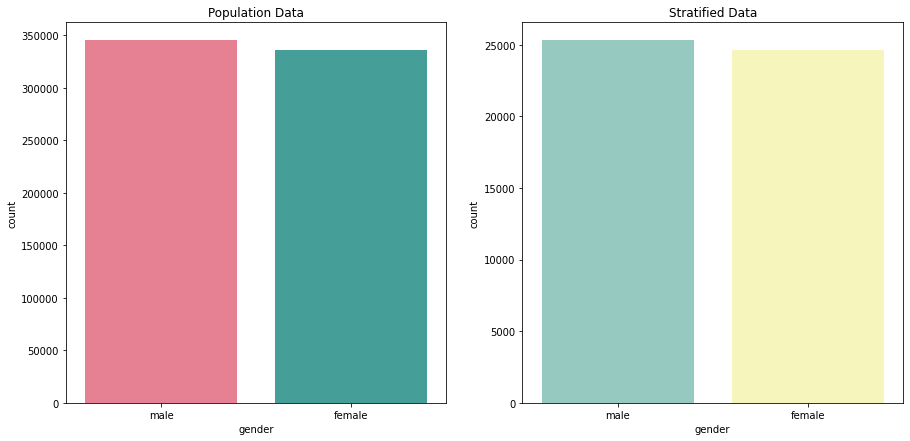

In [19]:
fig, ax =plt.subplots(1,2, figsize=(15, 7))
sns.countplot(x="gender", data=df, palette="husl",order = df['gender'].value_counts().index, ax=ax[0])
ax[0].set_title("Population Data")
sns.countplot(x="gender", data=blog_df, palette="Set3", order = blog_df['gender'].value_counts().index, ax=ax[1])
ax[1].set_title("Stratified Data")
fig.show()

### ***Inference:-*** Stratifed data has maintained the gender distribution from population data.

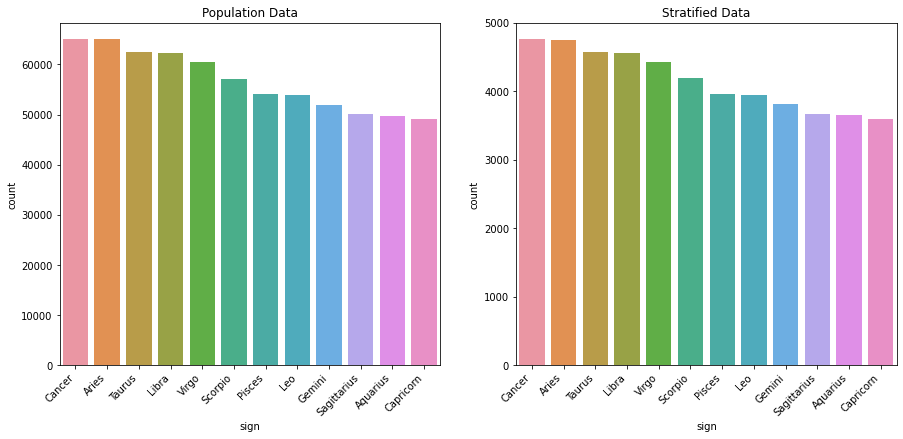

In [20]:
fig, ax =plt.subplots(1,2, figsize=(15, 7))
fig.autofmt_xdate(rotation=45)
sns.countplot(x="sign", data=df, order = df['sign'].value_counts().index, ax=ax[0])
ax[0].set_title("Population Data")
sns.countplot(x="sign", data=blog_df, order = blog_df['sign'].value_counts().index, ax=ax[1])
ax[1].set_title("Stratified Data")
fig.show()

### ***Inference:-*** Stratified data has maintained the Sun signs distribution from the population data.

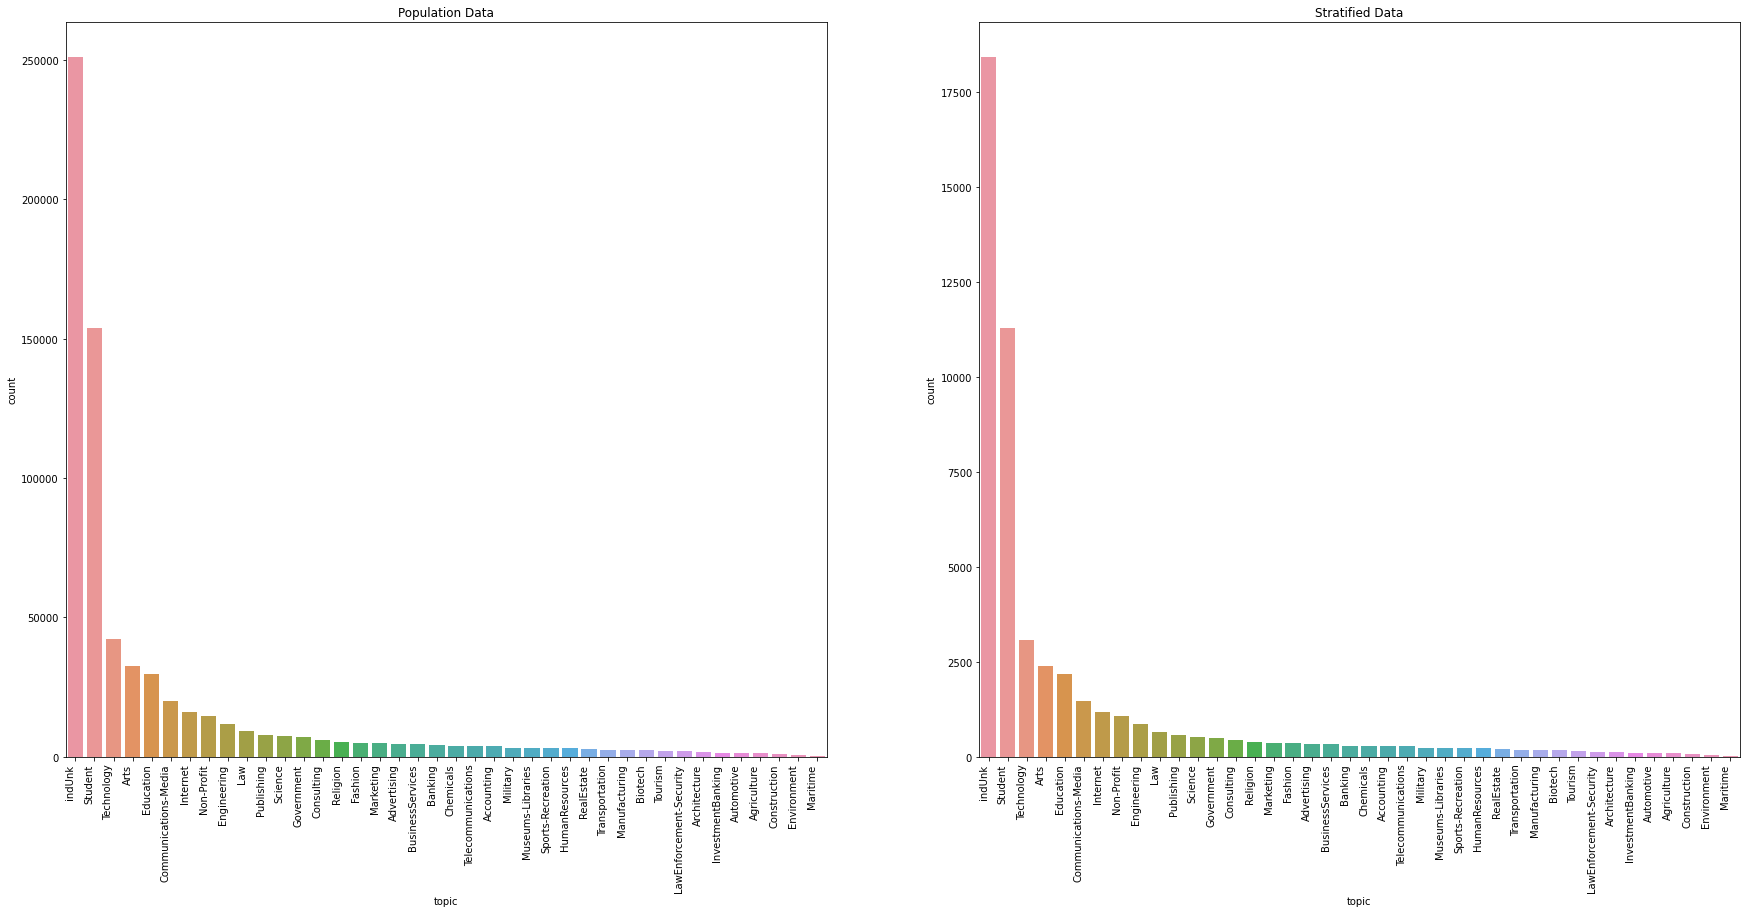

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(30, 15))
fig.autofmt_xdate(rotation=90)

sns.countplot(x='topic', data=df, order = df['topic'].value_counts().index, ax=ax[0])
ax[0].set_title("Population Data")

sns.countplot(x='topic', data=blog_df,order = blog_df['topic'].value_counts().index, ax=ax[1])
ax[1].set_title("Stratified Data")

fig.show()

### ***Inference:-*** Stratified data has maintained the topic distribution from the population data.

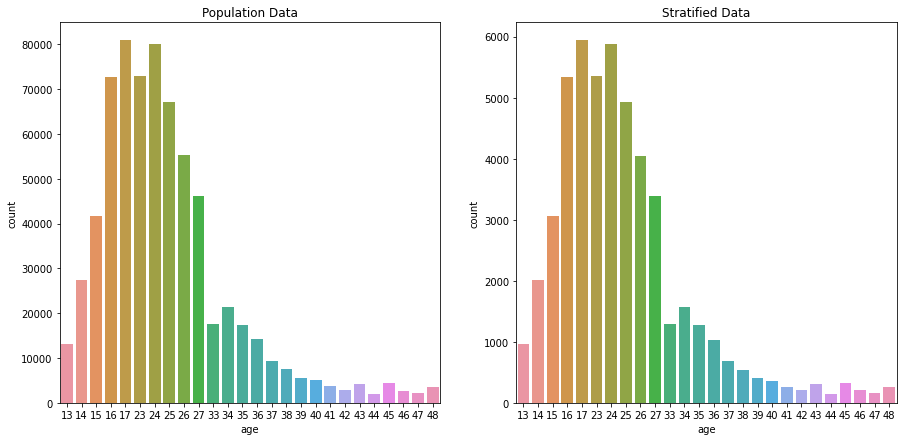

In [22]:
fig, ax =plt.subplots(1,2, figsize=(15, 7))
sns.countplot(x="age", data=df, ax=ax[0])
ax[0].set_title("Population Data")
sns.countplot(x="age", data=blog_df, ax=ax[1])
ax[1].set_title("Stratified Data")
fig.show()

### ***Inference:-*** Stratified data has kept the age distribution according to the population data.

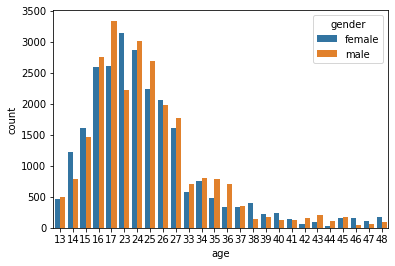

In [23]:
sns.countplot(x="age", hue="gender", data=blog_df)

### ***Inference:-*** Gender distribution is more or less balanced in the age category except for some.

# 2. Perform data pre-processing on the data:

In [24]:
blog_df.text.head(5)

0            How Did You Know    by Gary Valenciano...
1            6, 8, 12    by Brian McKnight    Do yo...
2                     I have a number of blogs all ...
3           Went to the dentist, whew, not a good  ...
4           For the last couple of days, i have bee...
Name: text, dtype: object

### 2.1 Data cleansing by removing unwanted characters, spaces, stop words etc. Convert text to lowercase.

In [25]:
# removing unwanted characters other than alphanumeric
pattern = "[^\w ]"
blog_df.text = blog_df.text.apply(lambda s : re.sub(pattern,"",s))
blog_df.text.head(5)

0            How Did You Know    by Gary Valenciano...
1            6 8 12    by Brian McKnight    Do you ...
2                     I have a number of blogs all ...
3           Went to the dentist whew not a good  th...
4           For the last couple of days i have been...
Name: text, dtype: object

In [26]:
#converting text to lower
blog_df.text = blog_df.text.apply(lambda s: s.lower())
blog_df.text.head(5)

0            how did you know    by gary valenciano...
1            6 8 12    by brian mcknight    do you ...
2                     i have a number of blogs all ...
3           went to the dentist whew not a good  th...
4           for the last couple of days i have been...
Name: text, dtype: object

In [27]:
#removing unwanted spaces
blog_df.text = blog_df.text.apply(lambda s: s.strip())
blog_df.text.head(5)

0    how did you know    by gary valenciano    intr...
1    6 8 12    by brian mcknight    do you ever thi...
2    i have a number of blogs all over the wide ope...
3    went to the dentist whew not a good  thing i h...
4    for the last couple of days i have been having...
Name: text, dtype: object

In [28]:
#removing stopwords
stopwords = set(stopwords.words('english'))

blog_df.text = blog_df.text.apply(lambda t: ' '.join([words for words in t.split() if words not in stopwords]))
blog_df.text.head(5)

0    know gary valenciano intro remember well day c...
1    6 8 12 brian mcknight ever think ever cry slee...
2    number blogs wide open plains known world wide...
3    went dentist whew good thing get work done 2 c...
4    last couple days problems blogger allowed post...
Name: text, dtype: object

In [29]:
# drop id and date columns
blog_df.drop(labels=['id','date','index'], axis=1,inplace=True)
blog_df.head(5)

,gender,age,topic,sign,text
0,female,16,Accounting,Aquarius,know gary valenciano intro remember well day c...
1,female,16,Accounting,Aquarius,6 8 12 brian mcknight ever think ever cry slee...
2,female,23,Accounting,Aquarius,number blogs wide open plains known world wide...
3,female,24,Accounting,Aquarius,went dentist whew good thing get work done 2 c...
4,female,24,Accounting,Aquarius,last couple days problems blogger allowed post...


### 2.2 Target/label merger and transformation

In [30]:
blog_df['labels'] = blog_df.apply(lambda col : [col['gender'],col['age'],col['topic'],col['sign']], axis=1)
blog_df.head()

,gender,age,topic,sign,text,labels
0,female,16,Accounting,Aquarius,know gary valenciano intro remember well day c...,"[female, 16, Accounting, Aquarius]"
1,female,16,Accounting,Aquarius,6 8 12 brian mcknight ever think ever cry slee...,"[female, 16, Accounting, Aquarius]"
2,female,23,Accounting,Aquarius,number blogs wide open plains known world wide...,"[female, 23, Accounting, Aquarius]"
3,female,24,Accounting,Aquarius,went dentist whew good thing get work done 2 c...,"[female, 24, Accounting, Aquarius]"
4,female,24,Accounting,Aquarius,last couple days problems blogger allowed post...,"[female, 24, Accounting, Aquarius]"


### ***Inference:-*** As we want to make this into a multi-label classification problem, we are required to merge all the label columns together, so that we have all the labels together for a particular sentence.

In [31]:
#Droping gender,age,topic & sign as they are already merged to labels column
blog_dff = blog_df.drop(columns=['gender','age','topic','sign'], axis=1)
blog_dff.head()

,text,labels
0,know gary valenciano intro remember well day c...,"[female, 16, Accounting, Aquarius]"
1,6 8 12 brian mcknight ever think ever cry slee...,"[female, 16, Accounting, Aquarius]"
2,number blogs wide open plains known world wide...,"[female, 23, Accounting, Aquarius]"
3,went dentist whew good thing get work done 2 c...,"[female, 24, Accounting, Aquarius]"
4,last couple days problems blogger allowed post...,"[female, 24, Accounting, Aquarius]"


### 2.3 Train and test split

In [32]:
X= blog_dff.text
y = blog_dff.labels

In [33]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=2,test_size = 0.2)

In [34]:
# Randomly shuffle the training data
X_train, y_train = shuffle(X_train, y_train)

In [35]:
print("Dimesions of training data : ", X_train.shape)
print()
print("Dimesions of testing data : ", X_test.shape)

Dimesions of training data :  (39944,)

Dimesions of testing data :  (9987,)


### 2.4 Vectorisation, etc.

In [36]:
cvect = CountVectorizer(ngram_range=(1,2))
#Feeding training data to CountVectorizer
cvect.fit(X_train)

#Check the vocablury size
len(cvect.vocabulary_)

2695561

In [37]:
cvect.get_feature_names()[:10]

['00',
 '00 055384020296',
 '00 41',
 '00 bridge',
 '00 chance',
 '00 crushed',
 '00 den',
 '00 draw',
 '00 freezing',
 '00 iraqis']

In [38]:
X_train_ct = cvect.transform(X_train)
X_train_ct

<39944x2695561 sparse matrix of type '<class 'numpy.int64'>'
	with 7153175 stored elements in Compressed Sparse Row format>

In [39]:
print(X_train_ct)

  (0, 34034)	1
  (0, 34083)	1
  (0, 97725)	1
  (0, 97734)	1
  (0, 115896)	1
  (0, 117071)	1
  (0, 244884)	1
  (0, 245069)	1
  (0, 276113)	1
  (0, 276114)	1
  (0, 284249)	1
  (0, 284358)	1
  (0, 356476)	1
  (0, 356904)	1
  (0, 360779)	1
  (0, 360785)	1
  (0, 369289)	1
  (0, 369315)	1
  (0, 398937)	1
  (0, 399304)	1
  (0, 468750)	1
  (0, 468841)	1
  (0, 514982)	1
  (0, 516290)	1
  (0, 581728)	1
  :	:
  (39943, 1952309)	1
  (39943, 1952310)	1
  (39943, 2010195)	1
  (39943, 2011232)	1
  (39943, 2098837)	1
  (39943, 2098839)	1
  (39943, 2202875)	1
  (39943, 2204244)	1
  (39943, 2204434)	1
  (39943, 2205647)	1
  (39943, 2218308)	1
  (39943, 2220573)	1
  (39943, 2244163)	1
  (39943, 2244736)	1
  (39943, 2318093)	1
  (39943, 2318104)	1
  (39943, 2334024)	1
  (39943, 2334025)	1
  (39943, 2356816)	1
  (39943, 2357306)	1
  (39943, 2387850)	1
  (39943, 2392944)	1
  (39943, 2394241)	1
  (39943, 2512509)	1
  (39943, 2512563)	1


In [40]:
X_test_ct = cvect.transform(X_test)
X_test_ct

<9987x2695561 sparse matrix of type '<class 'numpy.int64'>'
	with 1248534 stored elements in Compressed Sparse Row format>

In [41]:
print(X_test_ct)

  (0, 85482)	1
  (0, 113561)	1
  (0, 140730)	1
  (0, 140966)	1
  (0, 292189)	2
  (0, 292618)	1
  (0, 292747)	1
  (0, 352831)	2
  (0, 353538)	1
  (0, 413941)	1
  (0, 414171)	1
  (0, 463412)	1
  (0, 590522)	1
  (0, 590961)	1
  (0, 662002)	1
  (0, 662649)	1
  (0, 672256)	1
  (0, 782367)	1
  (0, 782554)	1
  (0, 832467)	1
  (0, 832489)	1
  (0, 850716)	1
  (0, 852315)	1
  (0, 911822)	1
  (0, 913303)	1
  :	:
  (9986, 2323322)	1
  (9986, 2323619)	1
  (9986, 2326351)	1
  (9986, 2343966)	1
  (9986, 2346641)	1
  (9986, 2387082)	1
  (9986, 2387997)	3
  (9986, 2389521)	1
  (9986, 2390717)	1
  (9986, 2427229)	1
  (9986, 2438284)	1
  (9986, 2448848)	1
  (9986, 2449124)	1
  (9986, 2519420)	1
  (9986, 2576047)	1
  (9986, 2613110)	1
  (9986, 2613118)	1
  (9986, 2620325)	1
  (9986, 2628145)	1
  (9986, 2635605)	1
  (9986, 2636836)	1
  (9986, 2658746)	3
  (9986, 2685042)	1
  (9986, 2685150)	1
  (9986, 2688140)	1


In [42]:
label_counts=dict()

for labels in blog_df.labels.values:
    for label in labels:
        if label in label_counts:
            label_counts[str(label)]+=1
        else:
            label_counts[str(label)]=1

### ***Inference:-*** Creating a dictionary to get the count of every label *i.e.* the key will be label name and value will be the total count of the label. 

In [43]:
label_counts

{'female': 24630,
 '16': 1,
 'Accounting': 286,
 'Aquarius': 3655,
 '23': 1,
 '24': 1,
 '26': 1,
 'Advertising': 342,
 '25': 1,
 '33': 1,
 '15': 1,
 'Agriculture': 89,
 'Architecture': 118,
 '13': 1,
 'Arts': 2378,
 '14': 1,
 '27': 1,
 '35': 1,
 '36': 1,
 '37': 1,
 '42': 1,
 '47': 1,
 'Automotive': 90,
 'Banking': 293,
 'Biotech': 165,
 'BusinessServices': 330,
 'Chemicals': 287,
 'Communications-Media': 1473,
 '38': 1,
 'Construction': 81,
 '48': 1,
 '17': 1,
 'Consulting': 431,
 '34': 1,
 'Education': 2176,
 '40': 1,
 '44': 1,
 'Engineering': 853,
 '41': 1,
 'Environment': 41,
 'Fashion': 351,
 'Government': 504,
 'HumanResources': 220,
 'Internet': 1168,
 'Law': 663,
 'LawEnforcement-Security': 136,
 'Manufacturing': 170,
 'Marketing': 351,
 '43': 1,
 'Museums-Libraries': 224,
 'Non-Profit': 1071,
 'Publishing': 568,
 'RealEstate': 209,
 'Religion': 383,
 'Science': 531,
 'Sports-Recreation': 221,
 'Student': 11286,
 'Technology': 3084,
 'Telecommunications': 279,
 'Tourism': 138,
 

In [44]:
binarizer=MultiLabelBinarizer(classes=sorted(label_counts.keys()))

### ***Inference:-*** We have multiple labels and to deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s.

In [45]:
y_train = binarizer.fit_transform(y_train)
y_train

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [46]:
y_test = binarizer.transform(y_test)
y_test

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]])

# 3. Design, train, tune and test the best text classifier.

In [47]:
model=LogisticRegression(C=1.0, penalty='l1', dual=False, solver='liblinear', random_state=42, class_weight= 'balanced', max_iter=100) 
model=OneVsRestClassifier(model)
model.fit(X_train_ct,y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l1',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [48]:
model1 = LinearSVC(C=1.0, penalty='l1', dual=False, loss='squared_hinge')
model1 = OneVsRestClassifier(model1)
model1.fit(X_train_ct,y_train)

OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=False,
                                        fit_intercept=True, intercept_scaling=1,
                                        loss='squared_hinge', max_iter=1000,
                                        multi_class='ovr', penalty='l1',
                                        random_state=None, tol=0.0001,
                                        verbose=0),
                    n_jobs=None)

In [49]:
Ypred=model.predict(X_test_ct)
print("Accuracy : ",accuracy_score(y_test,Ypred))

Accuracy :  0.01842395113647742


In [50]:
Y_pred=model1.predict(X_test_ct)
print("Accuracy : ",accuracy_score(y_test,Y_pred))

Accuracy :  0.017622909782717532


### ***Inferences:-*** 
### 1.Trained model on OnevsRest Classifer using Logistics Regression classifer and SVC. 
### 2.OnevsRest with Logistic Regression gave better results in terms of test accuracy.
### 3.Comparing models based on loss or accuracy will not give correct results as we are dealing with Multi-label classification on an imbalanced dataset with baises.

# 4. Display and explain detail the classification report

In [51]:
# Classification Report
cr = classification_report(y_test, Ypred)
print("Classification Report 1:- ")
print(cr)

Classification Report 1:- 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0


In [52]:
# Classification Report
cr1 = classification_report(y_test, Y_pred)
print("Classification Report 2:- ")
print(cr1)

Classification Report 2:- 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0


# ***Inferences:-***
### 1. F1-Score usually lies between Precison and Recall and hence we can compare based on Precision and Recall only.
### 2. Now based different buisness use cases whether high precision or high recall is needed will be decided.
### 3. In our case since we are dealing with an imbalanced dataset, micro - average score will be appropriate as it takes into account each instances equally rather than its counter part macro - avgerage score which considers all classes equally.
### 4. The micro-average precision and recall score is calculated from the individual classes’ true positives (TPs), true negatives (TNs), false positives (FPs), and false negatives (FNs) of the model. 
### 5. In OnevsRest with Logistic Regression micro-avg recall is higher than OnevsRest with SVC.
### 6. In OnevsRest with SVC micro-avg precision is higher than OnevsRest with Logistic Regression.

## *Reason for low score:-*
### a. The dataset is a imbalanced multi-label classification problem.
### b. Using Statistical NLP approach limits from learning the context from the textual data which can exponentially help in proper classification.
### c. Here we have only used 7% of the total data while maintaining the imbalance due to less availabilty of computational resources.

# 5. Print the true vs predicted labels for any 5 entries from the dataset.

In [53]:
j=[]
for i in range(5):
  j.append(random.randint(300,len(Ypred)))
   
print("Records selected at random: ",j)

cnt=0
for k in j:
  print("\n\nPredicted Labels["+str(cnt)+"] : ", binarizer.inverse_transform(Ypred)[k])
  print("\nTrue Labels["+str(cnt)+"] : ", binarizer.inverse_transform(y_test)[k])
  cnt+=1

Records selected at random:  [2763, 3705, 3888, 7318, 8160]


Predicted Labels[0] :  ('Aries', 'Cancer', 'male')

True Labels[0] :  ('Capricorn', 'indUnk', 'male')


Predicted Labels[1] :  ('Sagittarius', 'indUnk', 'male')

True Labels[1] :  ('Non-Profit', 'Pisces', 'male')


Predicted Labels[2] :  ('indUnk',)

True Labels[2] :  ('Capricorn', 'Sports-Recreation', 'male')


Predicted Labels[3] :  ()

True Labels[3] :  ('Gemini', 'Non-Profit', 'male')


Predicted Labels[4] :  ('Education',)

True Labels[4] :  ('Aquarius', 'Education', 'female')


### ***Inferences:-*** Due to less score and modelling on partial data, some predictions are incomplete.

# PART 2


---



---


In [54]:
#import corpus file
with open("intents.json") as file:
    data = json.load(file)

In [55]:
#Display corpus
print(data)

{'intents': [{'tag': 'Intro', 'patterns': ['hi', 'how are you', 'is anyone there', 'hello', 'whats up', 'hey', 'yo', 'listen', 'please help me', 'i am learner from', 'i belong to', 'aiml batch', 'aifl batch', 'i am from', 'my pm is', 'blended', 'online', 'i am from', 'hey ya', 'knock knock', 'please guide me', 'talking to you for first time'], 'responses': ['Hi there, How can I help?', 'Hi! What are you looking for ?', 'Hello! How may I assist you ?'], 'context_set': ''}, {'tag': 'Exit', 'patterns': ['thank you', 'thanks', 'cya', 'see you', 'later', 'see you later', 'goodbye', 'i am leaving', 'have a Good day', 'you helped me', 'thanks a lot', 'thanks a ton', 'you are the best', 'great help', 'too good', 'you are a good learning buddy'], 'responses': ['Hope my assist was helpful, Good Bye', 'Talk to you later,Good Bye!', 'Good Bye, I hope your query is resolved'], 'context_set': ''}, {'tag': 'Olympus', 'patterns': ['olympus', 'explain me how olympus works', 'I am not able to understand

In [56]:
# initializing lemmatizer to get stem of words
lemmatizer = WordNetLemmatizer()
# Each list to create
words = []
classes = []
doc_X = []
doc_y = []
# Loop through all the intents
# tokenize each pattern and append tokens to words, the patterns and
# the associated tag to their associated list
for intent in data["intents"]:
    for pattern in intent["patterns"]:
        tokens = nltk.word_tokenize(pattern)
        words.extend(tokens)
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # add the tag to the classes if it's not there already 
    if intent["tag"] not in classes:
        classes.append(intent["tag"])
# lemmatize all the words in the vocab and convert them to lowercase
# if the words don't appear in punctuation
words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in string.punctuation]
# sorting the vocab and classes in alphabetical order and taking the # set to ensure no duplicates occur
words = sorted(set(words))
classes = sorted(set(classes))

In [57]:
print("Words:\n", words)

Words:
 ['a', 'able', 'access', 'activation', 'ada', 'adam', 'aifl', 'aiml', 'am', 'an', 'ann', 'anyone', 'are', 'artificial', 'backward', 'bad', 'bagging', 'batch', 'bayes', 'belong', 'best', 'blended', 'bloody', 'boosting', 'bot', 'buddy', 'ca', 'classification', 'contact', 'create', 'cross', 'cya', 'day', 'deep', 'delayed', 'did', 'diffult', 'do', 'ensemble', 'epoch', 'explain', 'first', 'for', 'forest', 'forward', 'from', 'function', 'good', 'goodbye', 'gradient', 'great', 'guide', 'hate', 'have', 'hell', 'hello', 'help', 'helped', 'hey', 'hi', 'hidden', 'hour', 'how', 'hyper', 'i', 'imputer', 'in', 'intelligence', 'is', 'jerk', 'joke', 'knn', 'knock', 'later', 'layer', 'learner', 'learning', 'leaving', 'link', 'listen', 'logistic', 'lot', 'machine', 'me', 'ml', 'my', "n't", 'naive', 'name', 'nb', 'net', 'network', 'neural', 'no', 'not', 'of', 'olympus', 'on', 'online', 'operation', 'opertions', 'otimizer', 'parameter', 'piece', 'please', 'pm', 'problem', 'propagation', 'raise', 'r

In [58]:
print("Labels:\n", classes)

Labels:
 ['Bot', 'Exit', 'Intro', 'NN', 'Olympus', 'Profane', 'SL', 'Ticket']


In [59]:
print(doc_X)

['hi', 'how are you', 'is anyone there', 'hello', 'whats up', 'hey', 'yo', 'listen', 'please help me', 'i am learner from', 'i belong to', 'aiml batch', 'aifl batch', 'i am from', 'my pm is', 'blended', 'online', 'i am from', 'hey ya', 'knock knock', 'please guide me', 'talking to you for first time', 'thank you', 'thanks', 'cya', 'see you', 'later', 'see you later', 'goodbye', 'i am leaving', 'have a Good day', 'you helped me', 'thanks a lot', 'thanks a ton', 'you are the best', 'great help', 'too good', 'you are a good learning buddy', 'olympus', 'explain me how olympus works', 'I am not able to understand olympus', 'olympus window not working', 'no access to olympus', 'unable to see link in olympus', 'no link visible on olympus', 'whom to contact for olympus', 'lot of problem with olympus', 'olympus is not a good tool', 'lot of problems with olympus', 'how to use olympus', 'teach me olympus', 'i am not able to understand svm', 'explain me how machine learning works', 'i am not able 

In [60]:
print(doc_y)

['Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Intro', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Exit', 'Olympus', 'Olympus', 'Olympus', 'Olympus', 'Olympus', 'Olympus', 'Olympus', 'Olympus', 'Olympus', 'Olympus', 'Olympus', 'Olympus', 'Olympus', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'SL', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'Bot', 'Bot', 'Bot', 'Bot', 'Bot', 'Bot', 'Bot', 'Bot', 'Bot', 'Profane', 'Profane', 'Profane', 'Profane', 'Profane', 'Profane', 'Profane', 'Profane', 'Profane', 'Profane', 'Ticket', 'Ticket', 'Ticket', 'Ticket',

In [61]:
# list for training data
training = []
out_empty = [0] * len(classes)
# creating the bag of words model
for idx, doc in enumerate(doc_X):
    bow = []
    text = lemmatizer.lemmatize(doc.lower())
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    # mark the index of class that the current pattern is associated
    # to
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1
    # add the one hot encoded BoW and associated classes to training 
    training.append([bow, output_row])
# shuffle the data and convert it to an array
random.shuffle(training)
training = np.array(training, dtype=object)
# split the features and target labels
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))# list for training data
training = []
out_empty = [0] * len(classes)
# creating the bag of words model
for idx, doc in enumerate(doc_X):
    bow = []
    text = lemmatizer.lemmatize(doc.lower())
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    # mark the index of class that the current pattern is associated to
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1
    # add the one hot encoded BoW and associated classes to training 
    training.append([bow, output_row])
# shuffle the data and convert it to an array
random.shuffle(training)
training = np.array(training, dtype=object)
# split the features and target labels
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

In [62]:
# defining some parameters
input_shape = (len(train_X[0]),)
output_shape = len(train_y[0])
epochs = 200

#Clear any existing model in memory
tf.keras.backend.clear_session()

# the deep learning model

#Initialize model
model = Sequential()

# Input layer 
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))

#Output layer
model.add(Dense(output_shape, activation = "softmax"))

#Defining optimizer
adam = tf.keras.optimizers.Adam(learning_rate=0.01, decay=1e-6)
#Configuring the model for training
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=["accuracy"])

# Model summary
print(model.summary())

# Training the model
model.fit(x=train_X, y=train_y, epochs=200, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               21120     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
Total params: 29,896
Trainable params: 29,896
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
5/5 [==============================] - 1s 3ms/step - loss: 2.0727 - accuracy: 0.1142
Epoch 2/200
5/5 

In [63]:
#Functions for Chatbot Sessions
def clean_text(text): 
  tokens = nltk.word_tokenize(text)
  tokens = [lemmatizer.lemmatize(word) for word in tokens]
  return tokens

def bag_of_words(text, vocab): 
  tokens = clean_text(text)
  bow = [0] * len(vocab)
  for w in tokens: 
    for idx, word in enumerate(vocab):
      if word == w: 
        bow[idx] = 1
  return np.array(bow)

def pred_class(text, vocab, labels): 
  bow = bag_of_words(text, vocab)
  result = model.predict(np.array([bow]))[0]
  thresh = 0.2
  y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]

  y_pred.sort(key=lambda x: x[1], reverse=True)
  return_list = []
  for r in y_pred:
    return_list.append(labels[r[0]])
  return return_list

def get_response(intents_list, intents_json): 
  tag = intents_list[0]
  list_of_intents = intents_json["intents"]
  for i in list_of_intents: 
    if i["tag"] == tag:
      result = random.choice(i["responses"])
      break
  return result

In [64]:
# Running the chatbot
print("BOT : Chat with the bot[Type 'quit' to stop] !")
print("\nBOT : If answer is not  right[Type '*'] !")
while True:
  #Reading Input
  message = input("\n\nYou: ")
  #Correcting chat
  if message.lower() == "*":
    print("\nBOT:Please rephrase your question and try again")
  #Stopping Chat
  if message.lower() == "quit":
    break
  #Predicting and printing response  
  intents = pred_class(message, words, classes)
  result = get_response(intents, data)
  print("\nBOT : ", result)

BOT : Chat with the bot[Type 'quit' to stop] !

BOT : If answer is not  right[Type '*'] !


You: yo

BOT :  Hi! What are you looking for ?


You: no access to olympus

BOT :  Connect with your Program Manager


You: *

BOT:Please rephrase your question and try again

BOT :  Hi! What are you looking for ?


You: what the hell

BOT :  Please use respectful words


You: what is deep learning

BOT :  Go to the Neural Network Section in Olympus portal


You: ada boosting

BOT :  Go to the Machine Learning module in Olympus portal


You: you did not help me

BOT :  Transferring the request to your Program Manager


You: name please

BOT :  I'm your virtual learning assistant


You: cya

BOT :  Talk to you later,Good Bye!


You: quit
